In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import netCDF4
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
def accum2rate(ds):
    """
    Function to convert accumulated variables to conventional ones.
    Definition to convert accumulated variables to instantaneous.
    Written by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    dnew = ds.copy(deep=True)
    oindex = dnew.time
    dnew = dnew.diff('time') / (dnew.time.diff('time').astype(float) / 1e9 )
    dnew = dnew.reindex(time=oindex)
    return dnew[1:]

In [4]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    """

    # accumulated variables & scaling factors
    accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                        'ttr': 1,
                        'tsr': 1,
                        'str': 1,
                        'ssr': 1,
                        'e': 1}
    accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                'ttr': 'W m$^{-2}$',
                                'tsr': 'W m$^{-2}$',
                                'str': 'W m$^{-2}$',
                                'ssr': 'W m$^{-2}$',
                                'e': 'm s$^{-1}$'}
    ds1 = ds.copy().squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'hDate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    ds2 = ds1.copy(deep=True)

    # # convert accumulated variables into instantaneous
    # for var, sf in accumulated_vars.items():
    #     if var in ds2.keys():
    #         var_name = var+"_rate" 
    #         ds2 = ds2.assign(new=lambda x: accum2rate(x[var]) * sf)
    #         ds2 = ds2.rename_vars({'new':str(var_name)})
    #         ds2[var_name].loc[dict(time=ds2.time[1:])] = accum2rate(ds2[var]) * sf
    #         # set first value to equal zero,
    #         # should be zero but isn't always
    #         ds2[var_name].loc[dict(time=ds2.time[0])] = 0
    #         ds2[var_name].attrs['units'] = accumulated_var_newunits[var]
    return ds2

In [5]:
def hourly2accum(ds, start_day='2023-10-18 09', end_day='2023-10-22 00', m2mm=True):
    """
    Function to convert hourly precipitation to accumulated precipitation in mm.
    Also truncates the data to the desired time period.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds_out: xarray dataset with precipitation accumulated in mm.
    """
    if m2mm:
        factor = 1000
    else:
        factor = 1
    ds_out = ds.copy(deep=True).sel(time=slice(start_day, end_day))
    ds_out['tp'] = ds_out.tp.cumsum(dim='time')*factor  # sum and convert to mm

    return ds_out

# Import data

In [6]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
babet_exp = {}
for exp in file_dir.keys():
    babet_exp[exp] = xr.open_mfdataset(os.path.join(file_dir[exp], '*.nc'), preprocess=preproc_ds, engine='netcdf4')

In [7]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

# Calculate cumulative total precipitation

ERA5: sum up 

IFS: Already cumulative from initialisation, just need to subtract precip at start of window

In [8]:
starttime = '2023-10-19 00' # used to be 18th # Same as Met Office, https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2023/2023_08_storm_babet.pdf
endtime = '2023-10-22 00' # Met Office uses 9 hours more

In [9]:
tp_era = hourly2accum(era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_babet_exp = {key:(value.tp.sel(time=endtime)-value.tp.sel(time=starttime))*1000 for (key,value) in babet_exp.items()}


In [68]:
babet_exp['curr'].latitude

<xarray.DataArray 'latitude' (latitude: 163)>
array([73.5 , 73.25, 73.  , 72.75, 72.5 , 72.25, 72.  , 71.75, 71.5 , 71.25,
       71.  , 70.75, 70.5 , 70.25, 70.  , 69.75, 69.5 , 69.25, 69.  , 68.75,
       68.5 , 68.25, 68.  , 67.75, 67.5 , 67.25, 67.  , 66.75, 66.5 , 66.25,
       66.  , 65.75, 65.5 , 65.25, 65.  , 64.75, 64.5 , 64.25, 64.  , 63.75,
       63.5 , 63.25, 63.  , 62.75, 62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25,
       61.  , 60.75, 60.5 , 60.25, 60.  , 59.75, 59.5 , 59.25, 59.  , 58.75,
       58.5 , 58.25, 58.  , 57.75, 57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25,
       56.  , 55.75, 55.5 , 55.25, 55.  , 54.75, 54.5 , 54.25, 54.  , 53.75,
       53.5 , 53.25, 53.  , 52.75, 52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25,
       51.  , 50.75, 50.5 , 50.25, 50.  , 49.75, 49.5 , 49.25, 49.  , 48.75,
       48.5 , 48.25, 48.  , 47.75, 47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25,
       46.  , 45.75, 45.5 , 45.25, 45.  , 44.75, 44.5 , 44.25, 44.  , 43.75,
       43.5 , 43.25, 43.  , 42.75, 42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25,
       41.  , 40.75, 40.5 , 40.25, 40.  , 39.75, 39.5 , 39.25, 39.  , 38.75,
       38.5 , 38.25, 38.  , 37.75, 37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25,
       36.  , 35.75, 35.5 , 35.25, 35.  , 34.75, 34.5 , 34.25, 34.  , 33.75,
       33.5 , 33.25, 33.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
Attributes:
    units:      degrees_north
    long_name:  latitude

# Cumulative total precipitation

In [69]:
babet_exp['curr'].longitude

<xarray.DataArray 'longitude' (longitude: 289)>
array([-27.  , -26.75, -26.5 , ...,  44.5 ,  44.75,  45.  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [10]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

tp_min = 0 # Precipitation in mm
tp_max = 200

p_min = 970 # Pressure in hPa
p_max= 1030

Text(0.5, 0.98, 'Cumulative precip for 18th to 22nd Oct 2023')

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


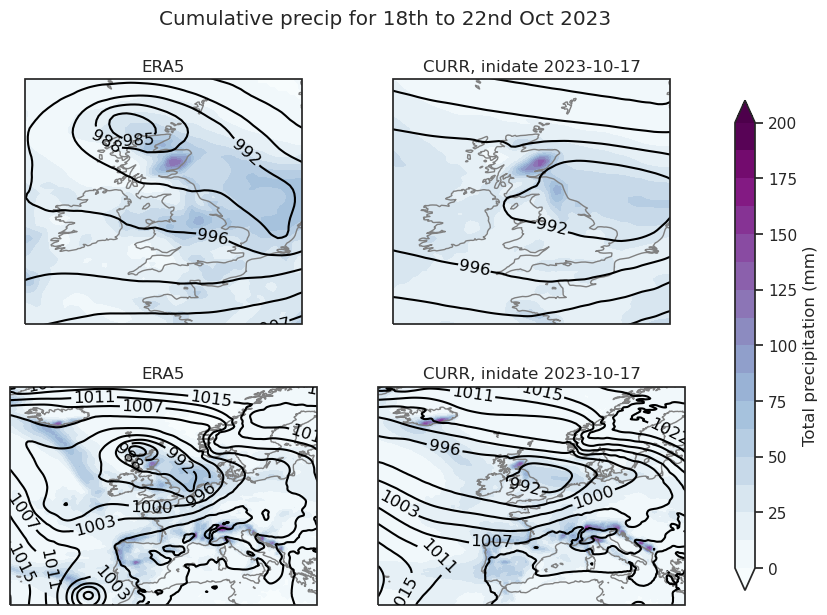

In [11]:
projection = ccrs.PlateCarree()

longitude =tp_era.longitude.values
latitude = tp_era.latitude.values
ini = '2023-10-17'

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# --- ERA5 UK ----------------------
# figure and map setup
fig = plt.figure(1, figsize=(10, 7))
ax = plt.subplot(2,2,1, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_era.values
p_vals = era5.msl.sel(time=endtime).values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')

plt.title('ERA5')

# --- CURR UK ----------------------
# figure and map setup
ax = plt.subplot(2,2,2, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_babet_exp['curr'].sel(inidate=ini).mean(dim='number').values
p_vals = babet_exp['curr'].sel(inidate=ini).msl.sel(time=endtime).mean(dim='number').values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')

plt.title(f'CURR, inidate {ini}')

# -------------- all of Europe --------------
lat_max = 70
lat_min = 33
lon_min = -27
lon_max = 25

# --- ERA5 EU ----------------------
# figure and map setup
ax = plt.subplot(2,2,3, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_era.values
p_vals = era5.msl.sel(time=endtime).values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')
plt.title('ERA5')

# --- CURR EU ----------------------
# figure and map setup
ax = plt.subplot(2,2,4, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# data for plotting
tp_vals = tp_babet_exp['curr'].sel(inidate=ini).mean(dim='number').values
p_vals = babet_exp['curr'].sel(inidate=ini).msl.sel(time=endtime).mean(dim='number').values/100

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 17)
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=plt.cm.BuPu,
                transform=projection, 
                extend='both')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection)
plt.clabel(cs, fmt='%d')
plt.title(f'CURR, inidate {ini}')

# colourbar, title etc
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Total precipitation (mm)')
plt.suptitle('Cumulative precip for 18th to 22nd Oct 2023')

# Comparison of precip in all simulations

In [12]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


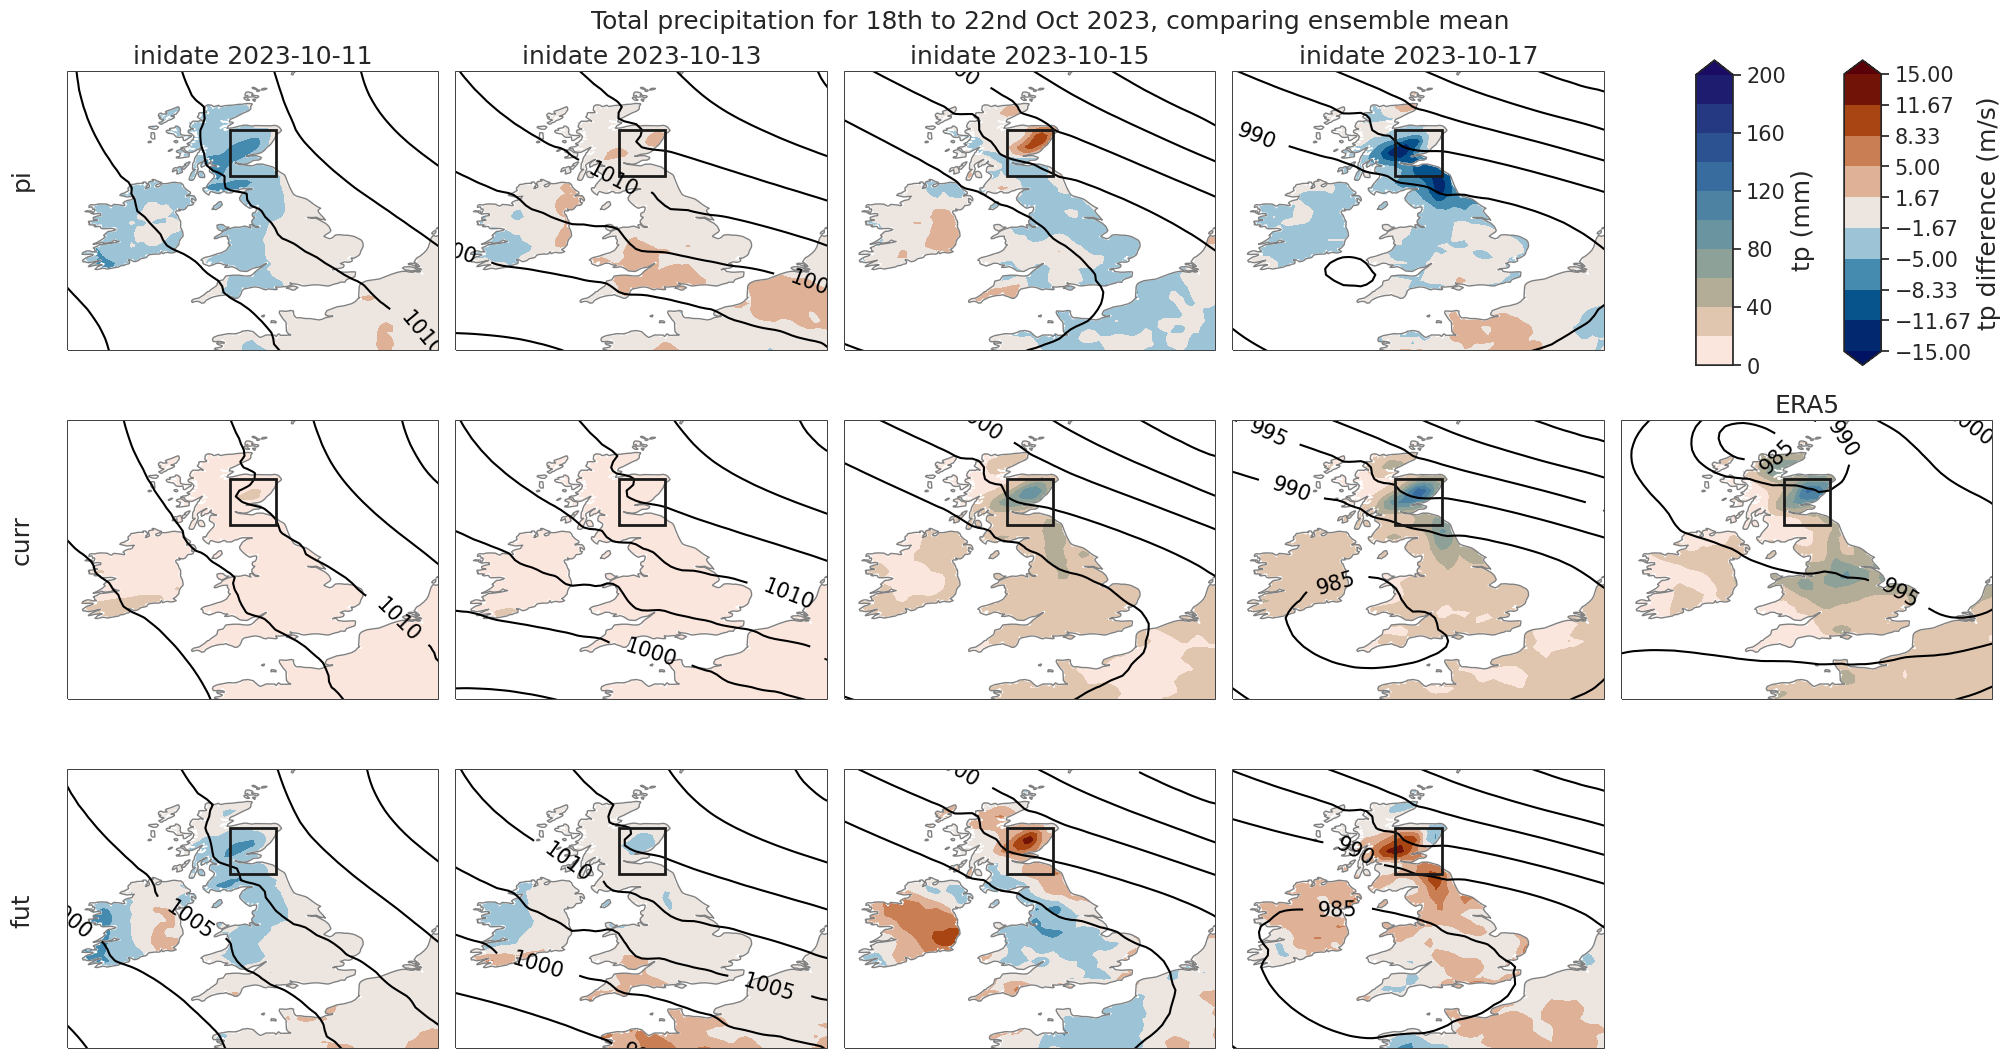

In [44]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

tp_min = 0
tp_max = 200

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# EPS data ------------------    
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (babet_exp[experiment].sel(inidate=inidate, time=slice(starttime, endtime))/100).mean(dim=['number', 'time']).msl.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            tp_vals = (tp_babet_exp[experiment].sel(inidate=inidate).mean(dim='number') - tp_babet_exp['curr'].sel(inidate=inidate).mean(dim='number')).values
        else: 
            tp_vals = tp_babet_exp[experiment].sel(inidate=inidate).mean(dim='number').values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_tp = np.linspace(-15, 15, 10)
            cf_diff = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 5)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.msl.sel(time=endtime).values/100
tp_vals = tp_era.values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 5)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp (mm)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='tp difference (mm)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='tp difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Total precipitation for 18th to 22nd Oct 2023, comparing ensemble mean', size = fs)
plt.tight_layout()

plt.savefig('figures/03_tp_all-inidates_all-experiments.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/03_tp_all-inidates_all-experiments.pdf')

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


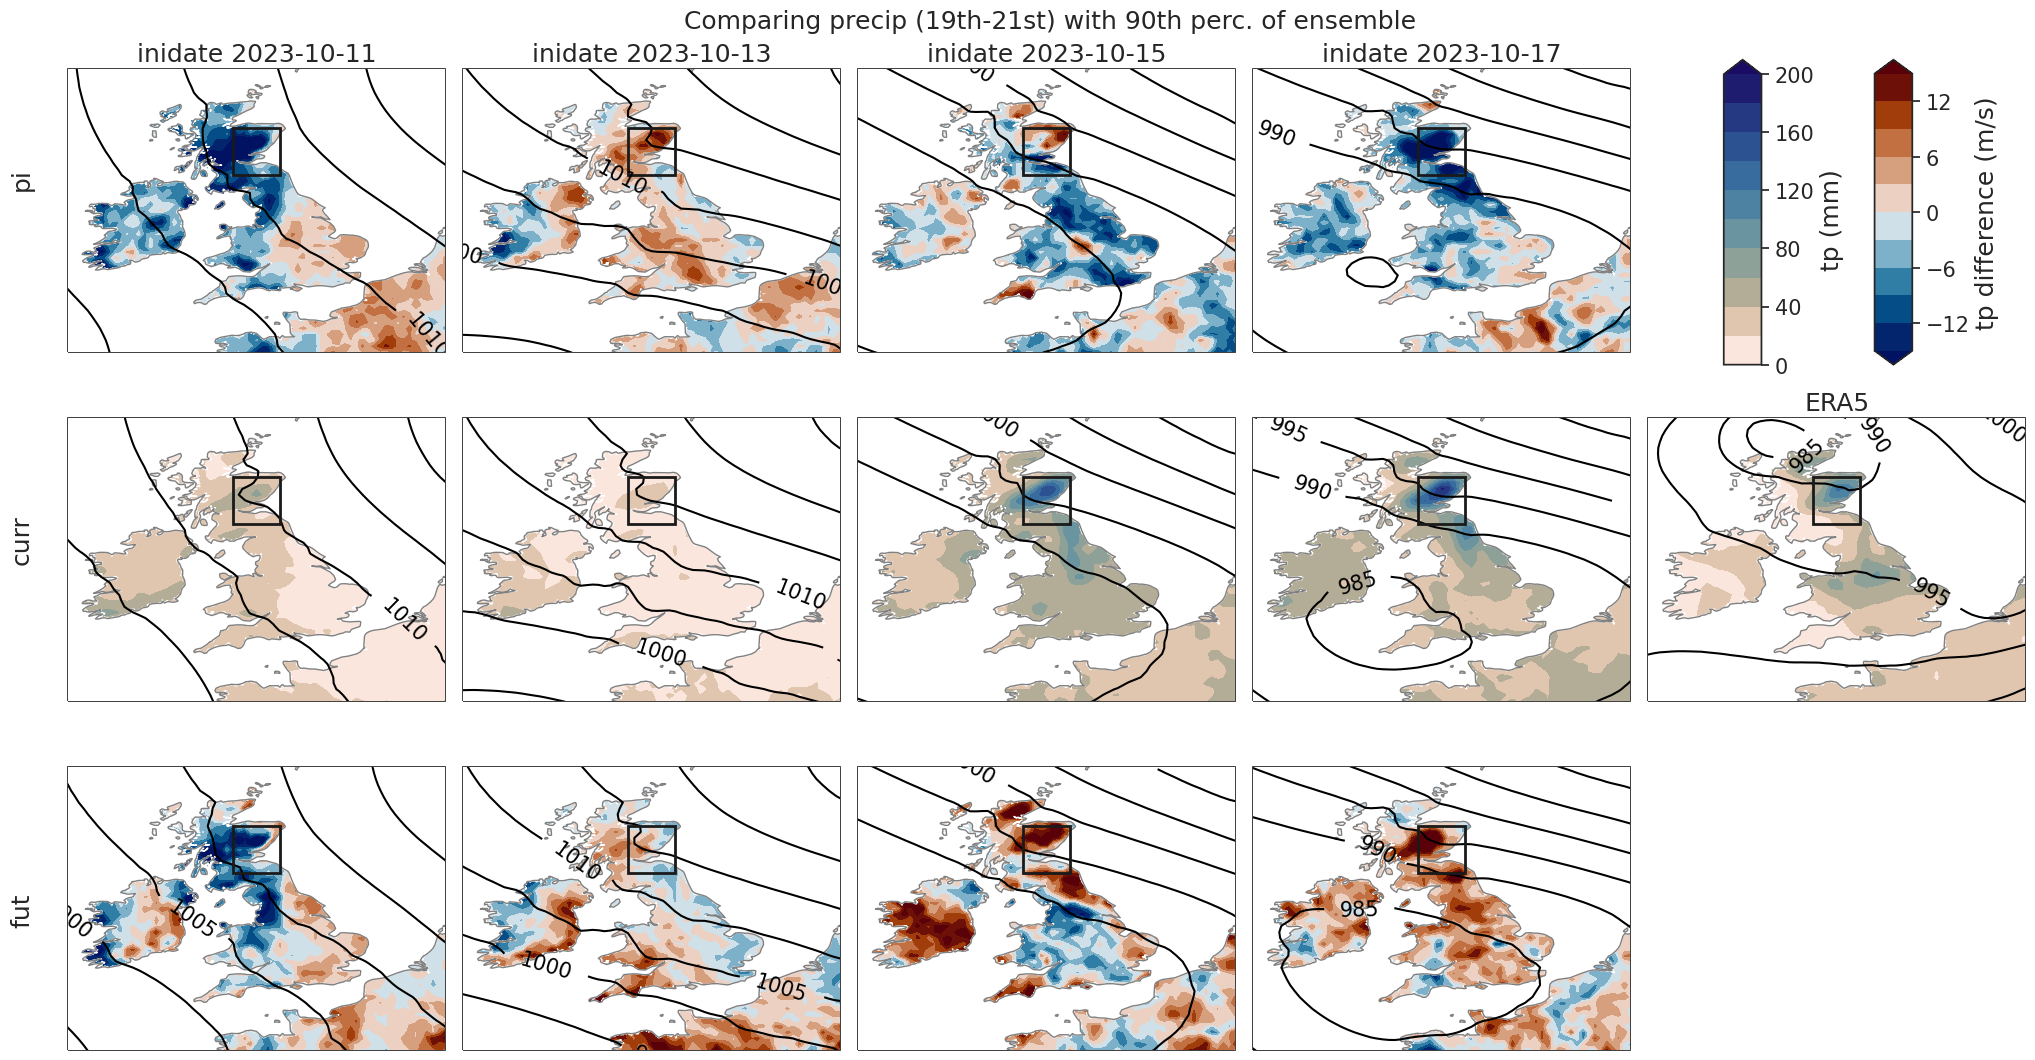

In [43]:
# figure and map setup
from tkinter import font


experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

tp_min = 0
tp_max = 200

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# EPS data ------------------    
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (babet_exp[experiment].sel(inidate=inidate, time=slice(starttime, endtime))/100).mean(dim=['number', 'time']).msl.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            tp_vals = (tp_babet_exp[experiment].sel(inidate=inidate).quantile(0.9,dim='number') - tp_babet_exp['curr'].sel(inidate=inidate).quantile(0.9,dim='number')).values
        else: 
            tp_vals = tp_babet_exp[experiment].sel(inidate=inidate).quantile(0.9,dim='number').values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_tp = np.linspace(-15, 15, 11)
            cf_diff = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 5)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.msl.sel(time=endtime).values/100
tp_vals = tp_era.values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 5)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp (mm)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='tp difference (mm)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='tp difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Comparing precip (19th-21st) with 90th perc. of ensemble', fontsize = fs)
plt.tight_layout()

# Change in precip compared to CC

In [70]:
# comparing the 90th percentile of ensemble as in plot
dt2m = {}
dtp = {}
for inidate in inidates:
    dt2m[inidate] = {}
    dtp[inidate] = {}

    t2m_curr = babet_exp['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00').quantile(0.9, dim='number').mean(dim=['latitude', 'longitude'])
    tp_curr = tp_babet_exp['curr'].sel(inidate=inidate).quantile(0.9, dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])
    for exp in ['pi', 'incr']:
        dt2m[inidate][exp] = (babet_exp[exp].t2m.sel(inidate=inidate, time='2023-10-19 00').quantile(0.9, dim='number').sum(dim=['latitude', 'longitude']) - t2m_curr)
        dtp[inidate][exp] = (tp_babet_exp[exp].sel(inidate=inidate).quantile(0.9, dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude']) - tp_curr)/tp_curr

        # calculate change per kelvin of temperature change
        dtpdt = dtp[inidate][exp]/dt2m[inidate][exp]
        print(f'{exp} {inidate}: {dtpdt.values}')

pi 2023-10-11: 4.067235636623567e-06
incr 2023-10-11: 4.805450761766218e-06
pi 2023-10-13: 7.234145930957564e-06
incr 2023-10-13: 5.727711998954813e-06
pi 2023-10-15: 5.828575903843008e-06
incr 2023-10-15: 6.470658594740509e-06
pi 2023-10-17: 5.129978321320622e-06
incr 2023-10-17: 6.5088487602962634e-06


In [67]:
# comparing the mean
dt2m = {}
dtp = {}
for inidate in inidates:
    dt2m[inidate] = {}
    dtp[inidate] = {}

    t2m_curr = babet_exp['curr'].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').mean(dim=['latitude', 'longitude'])
    tp_curr = tp_babet_exp['curr'].sel(inidate=inidate).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude'])
    for exp in ['pi', 'incr']:
        dt2m[inidate][exp] = (babet_exp[exp].t2m.sel(inidate=inidate, time='2023-10-19 00').mean(dim='number').mean(dim=['latitude', 'longitude']) - t2m_curr)
        dtp[inidate][exp] = (tp_babet_exp[exp].sel(inidate=inidate).mean(dim='number').sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).sum(dim=['latitude', 'longitude']) - tp_curr)/tp_curr

        # calculate change per kelvin of temperature change
        dtpdt = dtp[inidate][exp]/dt2m[inidate][exp]
        print(f'{exp} {inidate}: {dtpdt.values}')

pi 2023-10-11: 0.32882463932037354
incr 2023-10-11: -0.29243168234825134
pi 2023-10-13: -0.10057850182056427
incr 2023-10-13: -0.21483176946640015
pi 2023-10-15: -0.031605977565050125
incr 2023-10-15: 0.13778109848499298
pi 2023-10-17: 0.1859041303396225
incr 2023-10-17: 0.12191622704267502


# Ensemble spread

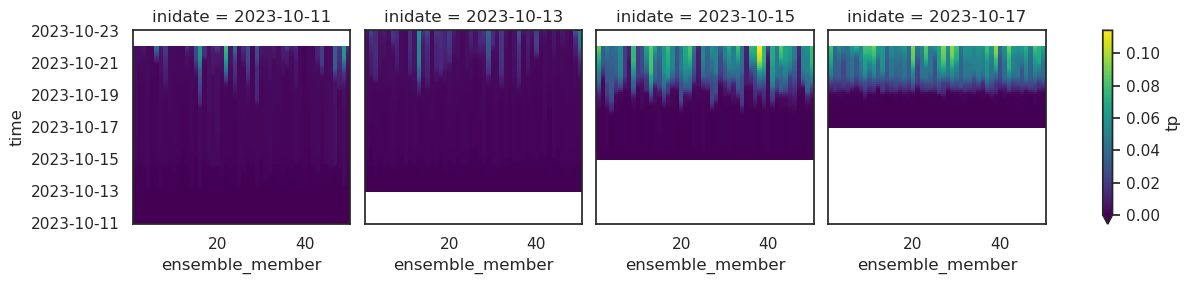

In [35]:
babet_exp['curr'].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).tp.plot(col='inidate', vmin=0)

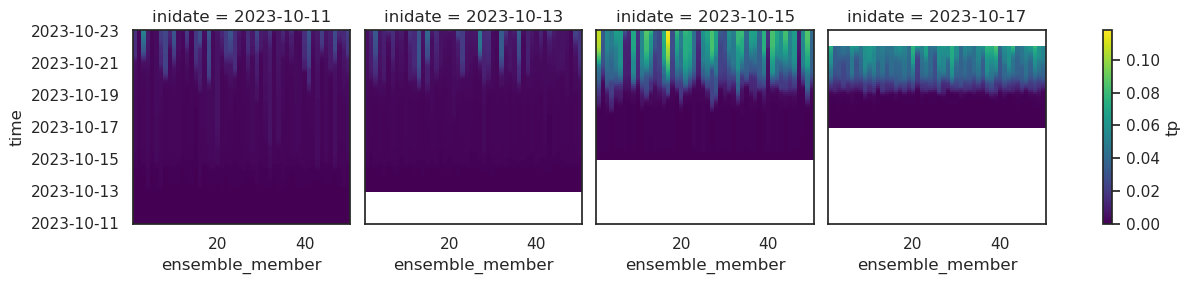

In [36]:
babet_exp['pi'].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).tp.plot(col='inidate', vmin=0)

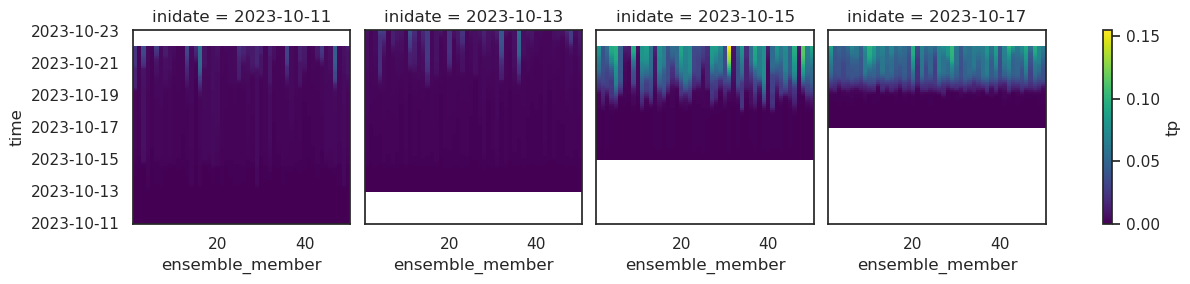

In [37]:
babet_exp['incr'].sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']).tp.plot(col='inidate', vmin=0)

In [38]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in t

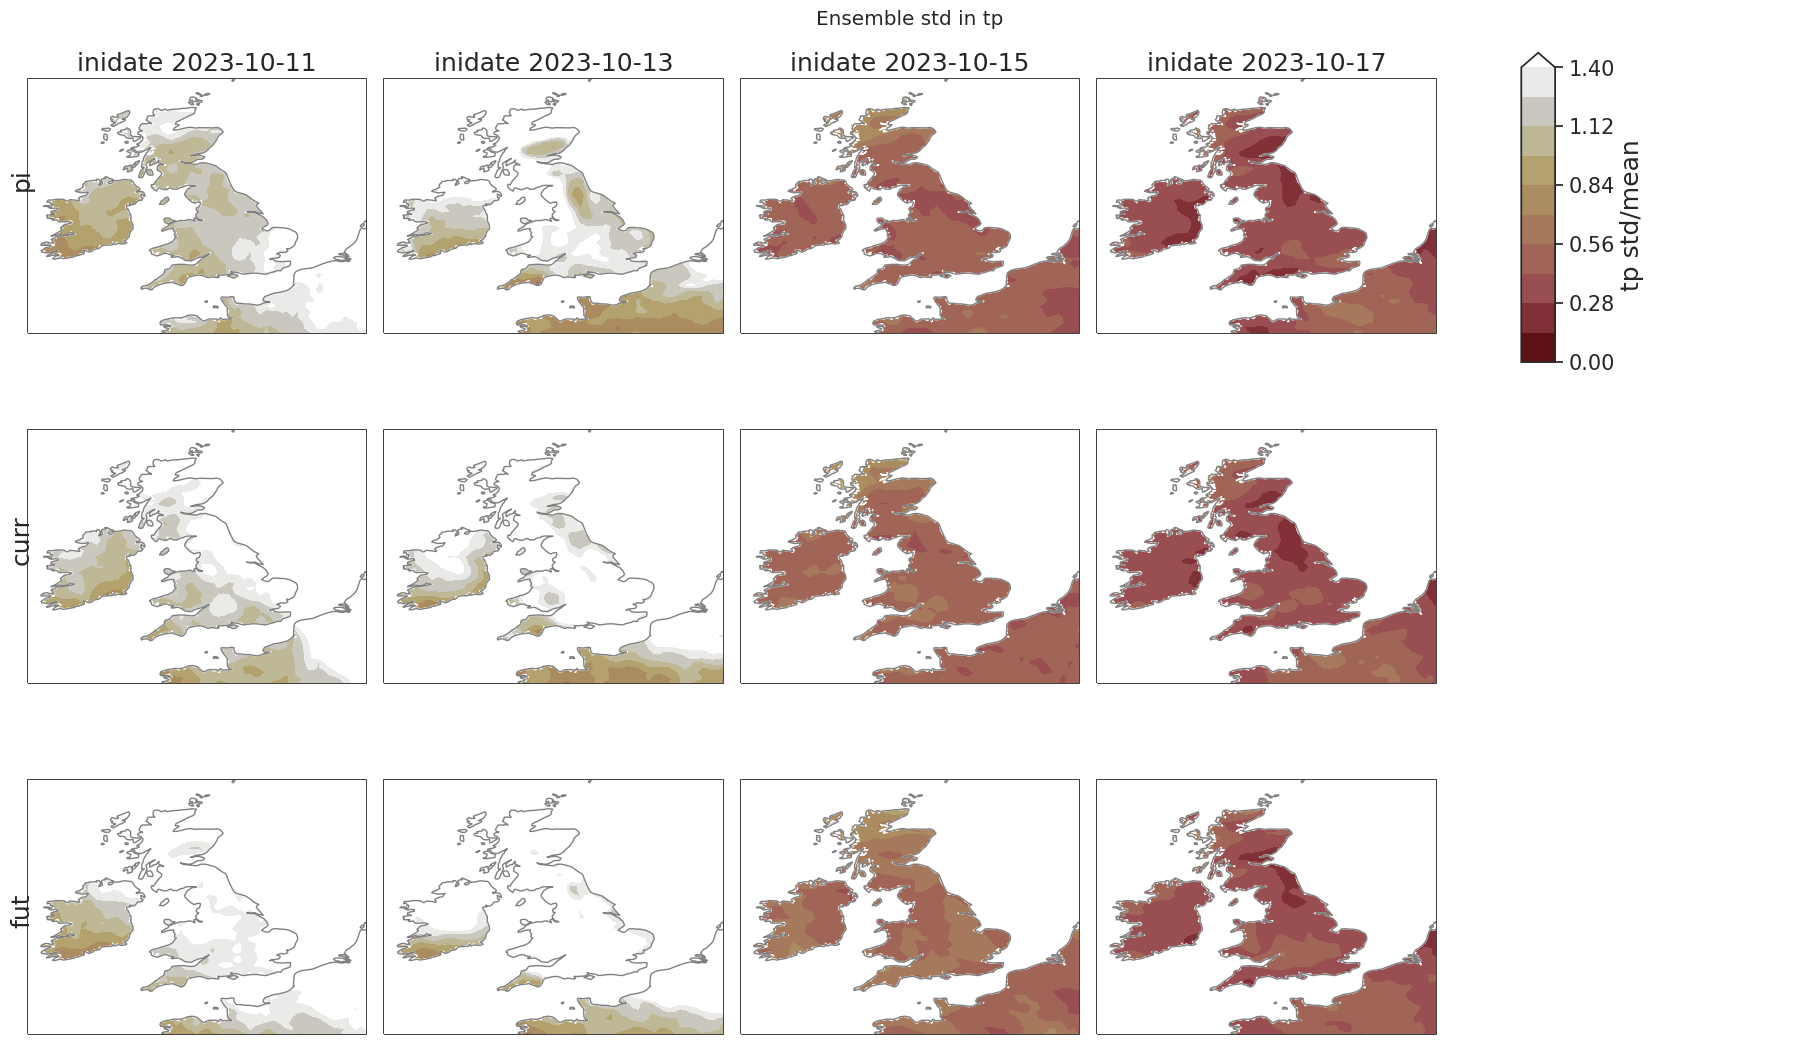

In [39]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

tp_min = 0
tp_max = 1.4

fig = plt.figure(1, figsize=(18, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']

# EPS data ------------------    
latitude = babet_exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = babet_exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (babet_exp[experiment].sel(inidate=inidate, time=endtime)/100).mean(dim='number').msl.values
        tp_vals = tp_babet_exp[experiment].sel(inidate=inidate).std(dim='number').values/tp_babet_exp[experiment].sel(inidate=inidate).mean(dim='number').values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp std as shading
        clevs_tp = np.linspace(tp_min, tp_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.bilbao,
                        transform=projection, zorder = 10, extend = 'max')
        
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))


# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp std/mean', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

plt.figtext(0.0, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(0.0, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(0.0, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Ensemble std in tp')
plt.tight_layout()